In [18]:
import os
import torch
import PIL
import numpy as np

import models
import torch.backends.cudnn as cudnn
from os.path import join
from lib.extract_patches import paint_border_overlap,extract_ordered_overlap,recompone_overlap
from lib.pre_processing import my_PreProc
from lib.dataset import TestDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

In [20]:
def readImg(im_fn,img_size=512):
    """
    When reading local image data, because the format of the data set is not uniform,
    the reading method needs to be considered. 
    Default using pillow to read the desired RGB format img
    """
    img = PIL.Image.open(im_fn)
    if img_size is not None:
        img = img.resize((img_size,img_size))
    return img


def load_images(img_list,img_size,patch_height, patch_width, stride_height, stride_width):
    imgs = None
    for i in range(len(img_list)):
        img = np.asarray(readImg(img_list[i]))
        imgs = np.expand_dims(img,0) if imgs is None else np.concatenate((imgs,np.expand_dims(img,0)))
    
    #Convert the dimension of imgs to [N,C,H,W]
    imgs = np.transpose(imgs,(0,3,1,2))
    print('ori data shape < ori_imgs:{}'.format(imgs.shape))
    print("imgs pixel range %s-%s: " %(str(np.min(imgs)),str(np.max(imgs))))
    print("==================data have loaded======================")
    
    test_imgs = my_PreProc(imgs)
    test_imgs = paint_border_overlap(test_imgs, patch_height, patch_width, stride_height, stride_width)
    print("\nTest images shape: {}, vaule range ({} - {}):"\
        .format(test_imgs.shape, str(np.min(test_imgs)), str(np.max(test_imgs))))
    
    patches_imgs_test = extract_ordered_overlap(test_imgs,patch_height,patch_width,stride_height,stride_width)
    print("test patches shape: {}, value range ({} - {})"\
        .format(patches_imgs_test.shape, str(np.min(patches_imgs_test)), str(np.max(patches_imgs_test))))
    return patches_imgs_test,imgs,test_imgs.shape[2], test_imgs.shape[3]

def inference(net,test_loader,new_width,new_height,img_height,img_width,stride_height,stride_width):
        net.eval()
        preds = []
        with torch.no_grad():
            for batch_idx, inputs in tqdm(enumerate(test_loader), total=len(test_loader)):
                inputs = inputs.cuda()
                outputs = net(inputs)
                outputs = outputs[:,1].data.cpu().numpy()
                preds.append(outputs)
        predictions = np.concatenate(preds, axis=0)
        pred_patches = np.expand_dims(predictions,axis=1)
        
        pred_imgs = recompone_overlap(
            pred_patches, new_height, new_width, stride_height, stride_width)
        ## restore to original dimensions
        pred_imgs = pred_imgs[:, :, 0:img_height, 0:img_width]
        
        return pred_imgs


        
class Config:
    test_patch_height = 96
    test_patch_width = 96
    stride_height = 16
    stride_width =16
    img_size = 512

In [21]:
args=Config()
path="/path/IDRiD/Segmentation/images/val"
img_list = [path+"/"+f for f in os.listdir(path)]

patches_imgs_test,imgs,new_height,new_width = load_images(img_list[:3],args.img_size,args.test_patch_height,args.test_patch_width,args.stride_height,args.stride_width)

ori data shape < ori_imgs:(3, 3, 512, 512)
imgs pixel range 0-255: 
==================data have loaded======================
new padded images shape: (3, 1, 512, 512)

Test images shape: (3, 1, 512, 512), vaule range (0.00784313725490196 - 1.0):
Number of patches on h : 27
Number of patches on w : 27
number of patches per image: 729, totally for testset: 2187
test patches shape: (2187, 1, 96, 96), value range (0.00784313725490196 - 1.0)


In [22]:
test_set = TestDataset(patches_imgs_test)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=3)

In [24]:
patch_height = args.test_patch_height
patch_width = args.test_patch_width
stride_height = args.stride_height
stride_width = args.stride_width

In [6]:
#$test_img = paint_border_overlap(test_img, patch_height, patch_width, stride_height, stride_width)
#patches_img_test = extract_ordered_overlap(test_img,patch_height,patch_width,stride_height,stride_width)
#print(test_img.shape)
#inputs=torch.from_numpy(patches_img_test).float()

new padded images shape: (1, 1, 2848, 4288)
Number of patches on h : 173
Number of patches on w : 263
number of patches per image: 45499, totally for testset: 45499


In [15]:
save_path ="experiments/UNet_vessel_seg/"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# net = models.UNetFamily.Dense_Unet(1,2).to(device)
net = models.LadderNet(inplanes=1, num_classes=2, layers=3, filters=16).to(device)
cudnn.benchmark = True

# Load checkpoint
print('==> Loading checkpoint...')
checkpoint = torch.load(join(save_path, 'best_model.pth'))
net.load_state_dict(checkpoint['net'])

==> Loading checkpoint...


<All keys matched successfully>

In [25]:
x=inference(net,test_loader,new_height=new_height,new_width=new_width,img_height=new_height,img_width=new_width,stride_height=stride_height,stride_width=stride_width)

100%|██████████| 2187/2187 [00:22<00:00, 99.24it/s] 


There are 3 images in Testset


In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.imshow(x[0])

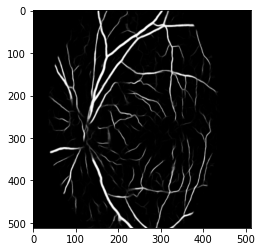

In [32]:
plt.imshow(x[0][0],cmap="gray")

In [51]:
def concat_result2(ori_img,pred_res):
    from copy import deepcopy
    ori_img = data = np.transpose(ori_img,(1,2,0))
    pred_res = data = np.transpose(pred_res,(1,2,0))

    binary = deepcopy(pred_res)
    binary[binary>=0.5]=1
    binary[binary<0.5]=0  

    if ori_img.shape[2]==3:
        pred_res = np.repeat((pred_res*255).astype(np.uint8),repeats=3,axis=2)
        binary = np.repeat((binary*255).astype(np.uint8),repeats=3,axis=2)
    total_img = np.concatenate((ori_img,pred_res,binary),axis=1)
    return total_img

def save_pred_single(pred_images,save_path):
    for i,img in enumerate(pred_images):
        img=np.squeeze(np.transpose(img,(1,2,0)),axis=2)
        plt.imsave(save_path+"/"+str(i)+"_pred.png",cmap="gray")

In [53]:
save_pred_single(x,"test_pred/")

In [60]:
img=img=np.squeeze(np.transpose(x[0],(1,2,0)),axis=2)
plt.imsave("test_pred/test.png",img,cmap="gray")

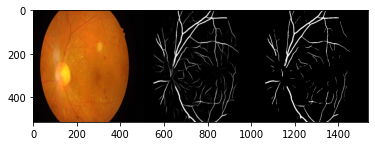

In [37]:
plt.imshow(concat_result2(imgs[0],x[0]))

In [ ]:
import joblib,copy
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import torch,sys
from tqdm import tqdm

from collections import OrderedDict
from lib.visualize import save_img,group_images,concat_result
import os
import argparse
from lib.logger import Logger, Print_Logger
from lib.extract_patches import *
from os.path import join
from lib.dataset import TestDataset
from lib.metrics import Evaluate
import models
from lib.common import setpu_seed,dict_round
from config import parse_args
from lib.pre_processing import my_PreProc

setpu_seed(2021)

def readImg(im_fn,img_size=512):
    """
    When reading local image data, because the format of the data set is not uniform,
    the reading method needs to be considered. 
    Default using pillow to read the desired RGB format img
    """
    img = PIL.Image.open(im_fn)
    if img_size is not None:
        img = img.resize((img_size,img_size))
    return img


def load_images(img_list,img_size,patch_height, patch_width, stride_height, stride_width):
    imgs = None
    for i in range(len(img_list)):
        img = np.asarray(readImg(img_list[i]))
        imgs = np.expand_dims(img,0) if imgs is None else np.concatenate((imgs,np.expand_dims(img,0)))
    
    #Convert the dimension of imgs to [N,C,H,W]
    imgs = np.transpose(imgs,(0,3,1,2))
    print('ori data shape < ori_imgs:{}'.format(imgs.shape))
    print("imgs pixel range %s-%s: " %(str(np.min(imgs)),str(np.max(imgs))))
    print("==================data have loaded======================")
    
    test_imgs = my_PreProc(imgs)
    test_imgs = paint_border_overlap(test_imgs, patch_height, patch_width, stride_height, stride_width)
    print("\nTest images shape: {}, vaule range ({} - {}):"\
        .format(test_imgs.shape, str(np.min(test_imgs)), str(np.max(test_imgs))))
    
    patches_imgs_test = extract_ordered_overlap(test_imgs,patch_height,patch_width,stride_height,stride_width)
    print("test patches shape: {}, value range ({} - {})"\
        .format(patches_imgs_test.shape, str(np.min(patches_imgs_test)), str(np.max(patches_imgs_test))))
    return patches_imgs_test,imgs,test_imgs.shape[2], test_imgs.shape[3]

class Predictor():
    def __init__(self, args,img_list,img_size):
        self.args = args
        self.img_list = img_list
        self.img_size = img_size
        assert (args.stride_height <= args.test_patch_height and args.stride_width <= args.test_patch_width)
        # save path
        self.path_experiment = join(args.outf, args.save)

        self.patches_imgs_test, self.test_imgs, self.new_height, self.new_width = load_images(
            img_list= self.img_list,
            img_size= self.img_size,
            patch_height=args.test_patch_height,
            patch_width=args.test_patch_width,
            stride_height=args.stride_height,
            stride_width=args.stride_width
        )
        self.img_height = self.test_imgs.shape[2]
        self.img_width = self.test_imgs.shape[3]

        test_set = TestDataset(self.patches_imgs_test)
        self.test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=3)

    # Inference prediction process
    def inference(self, net):
        net.eval()
        preds = []
        with torch.no_grad():
            for batch_idx, inputs in tqdm(enumerate(self.test_loader), total=len(self.test_loader)):
                inputs = inputs.cuda()
                outputs = net(inputs)
                outputs = outputs[:,1].data.cpu().numpy()
                preds.append(outputs)
        predictions = np.concatenate(preds, axis=0)
        self.pred_patches = np.expand_dims(predictions,axis=1)
        self.pred_imgs = recompone_overlap(
            self.pred_patches, self.new_height, self.new_width, self.args.stride_height, self.args.stride_width)
        ## restore to original dimensions
        self.pred_imgs = self.pred_imgs[:, :, 0:self.img_height, 0:self.img_width]
        return self.pred_imgs


def get_config():
    import argparse
    parser = argparse.ArgumentParser()

    # in/out
    parser.add_argument('--outf', default='./experiments',
                        help='trained model will be saved at here')
    parser.add_argument('--save', default='UNet_vessel_seg',
                        help='save name of experiment in args.outf directory')
    
    parser.add_argument('--batch_size', default=64,
                        type=int, help='batch size')
    # testing
    parser.add_argument("--test_data",type=str,default=None)
    parser.add_argument('--test_patch_height', default=96)
    parser.add_argument('--test_patch_width', default=96)
    parser.add_argument('--stride_height', default=16)
    parser.add_argument('--stride_width', default=16)

    # hardware setting
    parser.add_argument('--device', default=3, type=int,
                        help='Use GPU calculating')

    args = parser.parse_args()
    return args

        
if __name__ == '__main__':
    args = get_config()
    save_path = join(args.outf, args.save)
    device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.device)

    # net = models.UNetFamily.Dense_Unet(1,2).to(device)
    net = models.LadderNet(inplanes=1, num_classes=2, layers=3, filters=16).to(device)
    cudnn.benchmark = True

    # Load checkpoint
    print('==> Loading checkpoint...')
    checkpoint = torch.load(join(save_path, 'best_model.pth'))
    net.load_state_dict(checkpoint['net'])
    
    img_list = [ args.test_data +"/"+f for f in os.listdir(args.test_data)] 
    img_size = 512
    predictor = Predictor(args,img_list,img_size)
    pred_imgs=predictor.inference(net)
    print(pred_imgs.shape)

In [50]:
[os.path.basename(x).split(".")[0] for x in img_list]

['IDRiD_60',
 'IDRiD_64',
 'IDRiD_80',
 'IDRiD_77',
 'IDRiD_56',
 'IDRiD_57',
 'IDRiD_59',
 'IDRiD_58',
 'IDRiD_78',
 'IDRiD_67',
 'IDRiD_61',
 'IDRiD_79',
 'IDRiD_73',
 'IDRiD_71',
 'IDRiD_65',
 'IDRiD_74',
 'IDRiD_76',
 'IDRiD_69',
 'IDRiD_63',
 'IDRiD_62',
 'IDRiD_66',
 'IDRiD_55',
 'IDRiD_72',
 'IDRiD_68',
 'IDRiD_70',
 'IDRiD_81',
 'IDRiD_75']